# 论文复现赛之元学习MAML算法
## 1、项目概要
### 1.1 文献简介
Model-Agnostic Meta-Learning[1]（MAML）算法是一种模型无关的元学习算法，其模型无关体现在，能够与任何使用了梯度下降法的模型相兼容，广泛应用于各种不同的机器学习任务，包括分类、识别、强化学习等领域。

元学习的目标，是在大量不同的任务上训练一个模型，使其能够使用极少量的训练数据（即小样本），进行极少量的梯度下降步数，就能够迅速适应新任务，解决新问题。

在本项目复现的文献中，通过对模型参数进行显式训练，从而获得在各种任务下均能良好泛化的模型初始化参数。当面临小样本的新任务时，使用该初始化参数，能够在单步（或多步）梯度更新后，实现对该任务的学习和适配。为了复现文献中的实验结果，本项目基于paddlepaddle深度学习框架，在omniglot数据集上进行训练和测试，目标是达到并超过原文献的模型性能。

### 1.2 omniglot数据集
Omniglot 数据集包含50个不同的字母表，每个字母表中的字母各包含20个手写字符样本，每一个手写样本都是不同的人通过亚马逊的 Mechanical Turk 在线绘制的。Omniglot数据集的多样性强于MNIST数据集，是增强版的MNIST，常用与小样本识别任务。

![](https://ai-studio-static-online.cdn.bcebos.com/cd4e94bac7c3470e800cfb3426fdf8954c5c108ac9504b658be492b034a2fb6b)



## 2、系统方案
### 2.1 算法框架
考虑一个关于任务T的分布p(T)，我们希望模型能够对该任务分布很好的适配。在K-shot（即K个学习样本）的学习任务下，从p(T)分布中随机采样一个新任务Ti，在任务Ti的样本分布qi中随机采样K个样本，用这K个样本训练模型，获得LOSS，实现对模型f的内循环更新。然后再采样query个样本，评估新模型的LOSS，然后对模型f进行外循环更新。反复上述过程，从而使最终模型能够对任务分布p(T)上的所有情况，能够良好地泛化。算法可用下图进行示意。

 ![](https://ai-studio-static-online.cdn.bcebos.com/5c1cc7e52f7e4a3d98b9693a6e27309c72d041b310994d889640a29221e47c52)
 
2.2 算法流程
MAML算法针对小样本图像分类任务的计算流程，如下图所示：
 
 ![](https://ai-studio-static-online.cdn.bcebos.com/bd44f95ed7564189a010b04367f79ba15362cbf1dc9c491ea539ffb2b06dfa23)
 
本项目的难点在于，算法包含外循环和内循环两种梯度更新方式。内循环针对每一种任务T进行梯度更新，用更新后的模型重新评估LOSS；而外循环则要使用内循环中更新后的LOSS，在所有任务上更新原始模型。
使用paddle经典的动态图框架，在内循环更新完成后，模型各节点参数已经发生变化，loss已无法反传到先前的模型参数上。外循环的参数更新公式为

![](https://ai-studio-static-online.cdn.bcebos.com/2bf80b14ecee42d88b19eceae07ce5fa4a7d15f1cf764ce89ddee5b719270f51)


这里，要使用θ_i^'参数模型计算的LOSS，反传回θ，使用经典动态图模型架构无法实现。本方案通过自定义参数的方式，使函数层层级联，实现更灵活的参数控制。


## 3、系统代码和数据
### 3.1 数据准备与预处理（只需执行一遍）

本项目使用AI Studio上的“omniglot元学习数据集”，大小为64.6M。

首先解压数据集，并将images_background和images_evaluation路径下的内容，拷贝到“data/omniglot/”中。



In [ ]:
!unzip -oq /home/aistudio/data/data78550/omniglot_python.zip -d /home/aistudio/data/omniglot_pre
!cp -r /home/aistudio/data/omniglot_pre/images_background/. /home/aistudio/data/omniglot
!cp -r /home/aistudio/data/omniglot_pre/images_evaluation/. /home/aistudio/data/omniglot

对图像数据进行遍历、处理，构建训练集、验证集和测试集的numpy格式数据，并保存到工程根目录下。

In [ ]:
import os
import cv2
import numpy as np
import random

data_folder = './data/omniglot'  # omniglot数据集路径

character_folders = [os.path.join(data_folder, family, character) \
                     for family in os.listdir(data_folder) \
                     if os.path.isdir(os.path.join(data_folder, family)) \
                     for character in os.listdir(os.path.join(data_folder, family))]
print("The number of character folders: {}".format(len(character_folders)))  # 1623
random.seed(1)
random.shuffle(character_folders)
train_folders = character_folders[:973]
val_folders = character_folders[973:1298]
test_folders = character_folders[1298:]
print('The number of train characters is {}'.format(len(train_folders)))  # 973
print('The number of validation characters is {}'.format(len(val_folders)))  # 325
print('The number of test characters is {}'.format(len(test_folders)))  # 325

train_imgs_list = []
for char_fold in train_folders:
    char_list = []
    for file in [os.path.join(char_fold, f) for f in os.listdir(char_fold)]:
        img = cv2.imread(file)
        img = cv2.resize(img, (28, 28))
        img = np.transpose(img, (2, 0, 1))
        img = img[0].astype('float32')  # 只取零通道
        img = img / 255.0
        img = img * 2.0 - 1.0
        char_list.append(img)
    char_list = np.array(char_list)
    train_imgs_list.append(char_list)
train_imgs = np.array(train_imgs_list)
train_imgs = train_imgs[:, :, np.newaxis, :, :]
print('The shape of train_imgs: {}'.format(train_imgs.shape))  # [973,20,1,28,28]

val_imgs_list = []
for char_fold in val_folders:
    char_list = []
    for file in [os.path.join(char_fold, f) for f in os.listdir(char_fold)]:
        img = cv2.imread(file)
        img = cv2.resize(img, (28, 28))
        img = np.transpose(img, (2, 0, 1))
        img = img[0].astype('float32')  # 只取零通道
        img = img / 255.0
        img = img * 2.0 - 1.0
        char_list.append(img)
    char_list = np.array(char_list)
    val_imgs_list.append(char_list)
val_imgs = np.array(val_imgs_list)
val_imgs = val_imgs[:, :, np.newaxis, :, :]
print('The shape of val_imgs: {}'.format(val_imgs.shape))  # [325,20,1,28,28]

test_imgs_list = []
for char_fold in test_folders:
    char_list = []
    for file in [os.path.join(char_fold, f) for f in os.listdir(char_fold)]:
        img = cv2.imread(file)
        img = cv2.resize(img, (28, 28))
        img = np.transpose(img, (2, 0, 1))
        img = img[0].astype('float32')  # 只取零通道
        img = img / 255.0
        img = img * 2.0 - 1.0
        char_list.append(img)
    char_list = np.array(char_list)
    test_imgs_list.append(char_list)
test_imgs = np.array(test_imgs_list)
test_imgs = test_imgs[:, :, np.newaxis, :, :]
print('The shape of test_imgs: {}'.format(test_imgs.shape))  # [325,20,1,28,28]

np.save(os.path.join('omniglot_train.npy'), train_imgs)
np.save(os.path.join('omniglot_val.npy'), val_imgs)
np.save(os.path.join('omniglot_test.npy'), test_imgs)



The number of character folders: 1623
The number of train characters is 973
The number of validation characters is 325
The number of test characters is 325
The shape of train_imgs: (973, 20, 1, 28, 28)
The shape of val_imgs: (325, 20, 1, 28, 28)
The shape of test_imgs: (325, 20, 1, 28, 28)


打开并显示四个样本。

(-0.5, 27.5, 27.5, -0.5)

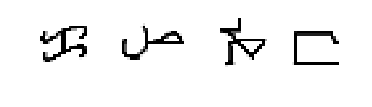

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# 加载训练集和测试集
x_train = np.load('omniglot_train.npy')  # (964, 20, 1, 28, 28)
plt.subplot(1,4,1)
plt.imshow(x_train[0,0,0,:,:], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(x_train[1,0,0,:,:], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(x_train[2,0,0,:,:], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(x_train[3,0,0,:,:], cmap=plt.cm.gray)
plt.axis('off')


### 3.2 训练脚本及日志
#### 3.3.1 导入库，并设置全局训练参数


In [1]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import numpy as np
import random
import time
from copy import deepcopy, copy
from tqdm import tqdm
import pickle

# 加载训练集和测试集
x_train = np.load('omniglot_train.npy')  # (973, 20, 1, 28, 28)
x_val = np.load('omniglot_val.npy')  # (325, 20, 1, 28, 28)
x_test = np.load('omniglot_test.npy')  # (325, 20, 1, 28, 28)
datasets = {'train': x_train, 'val': x_val, 'test': x_test}

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


5-way-1-shot修改配置如下：n_way = 5, k_spt = 1

5-way-5-shot修改配置如下：n_way = 5, k_spt = 5

20-way-1-shot修改配置如下：n_way = 20, k_spt = 1

20-way-5-shot修改配置如下：n_way = 20, k_spt = 5


In [2]:
# 全局参数设置
n_way = 5
k_spt = 1  # support data 的个数
k_query = 15  # query data 的个数
imgsz = 28
resize = imgsz
task_num = 32
batch_size = task_num
glob_update_step = 5
glob_update_step_test = 5
glob_meta_lr = 0.001  # 外循环学习率
glob_base_lr = 0.1  # 内循环学习率

indexes = {"train": 0, "val": 0, "test": 0}
print("DB: train", x_train.shape, "validation", x_val.shape, "test", x_test.shape)


DB: train (973, 20, 1, 28, 28) validation (325, 20, 1, 28, 28) test (325, 20, 1, 28, 28)


定义函数load_data_cache，用于加载若干组batch数据。

In [3]:
def load_data_cache(dataset):
    """
    Collects several batches data for N-shot learning
    :param dataset: [cls_num, 20, 84, 84, 1]
    :return: A list with [support_set_x, support_set_y, target_x, target_y] ready to be fed to our networks
    """
    #  take 5 way 1 shot as example: 5 * 1
    setsz = k_spt * n_way
    querysz = k_query * n_way
    data_cache = []

    # print('preload next 10 caches of batch_size of batch.')
    for sample in range(50):  # num of epochs

        x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
        for i in range(batch_size):  # one batch means one set

            x_spt, y_spt, x_qry, y_qry = [], [], [], []
            selected_cls = np.random.choice(dataset.shape[0], n_way, replace=False)

            for j, cur_class in enumerate(selected_cls):
                selected_img = np.random.choice(20, k_spt + k_query, replace=False)

                # 构造support集和query集
                x_spt.append(dataset[cur_class][selected_img[:k_spt]])
                x_qry.append(dataset[cur_class][selected_img[k_spt:]])
                y_spt.append([j for _ in range(k_spt)])
                y_qry.append([j for _ in range(k_query)])

            # shuffle inside a batch
            perm = np.random.permutation(n_way * k_spt)
            x_spt = np.array(x_spt).reshape(n_way * k_spt, 1, resize, resize)[perm]
            y_spt = np.array(y_spt).reshape(n_way * k_spt)[perm]
            perm = np.random.permutation(n_way * k_query)
            x_qry = np.array(x_qry).reshape(n_way * k_query, 1, resize, resize)[perm]
            y_qry = np.array(y_qry).reshape(n_way * k_query)[perm]

            # append [sptsz, 1, 84, 84] => [batch_size, setsz, 1, 84, 84]
            x_spts.append(x_spt)
            y_spts.append(y_spt)
            x_qrys.append(x_qry)
            y_qrys.append(y_qry)

        #         print(x_spts[0].shape)
        # [b, setsz = n_way * k_spt, 1, 28, 28]
        x_spts = np.array(x_spts).astype(np.float32).reshape(batch_size, setsz, 1, resize, resize)
        y_spts = np.array(y_spts).astype(np.int64).reshape(batch_size, setsz)
        # [b, qrysz = n_way * k_query, 1, 28, 28]
        x_qrys = np.array(x_qrys).astype(np.float32).reshape(batch_size, querysz, 1, resize, resize)
        y_qrys = np.array(y_qrys).astype(np.int64).reshape(batch_size, querysz)
        #         print(x_qrys.shape)
        data_cache.append([x_spts, y_spts, x_qrys, y_qrys])

    return data_cache

获取训练和测试时用到的数据。

In [4]:
datasets_cache = {"train": load_data_cache(x_train),  # current epoch data cached
                  "val": load_data_cache(x_val),
                  "test": load_data_cache(x_test)}

获取一个batch的数据。

In [5]:
def next(mode='train'):
    """
    Gets next batch from the dataset with name.
    :param mode: The name of the splitting (one of "train", "val", "test")
    :return:
    """
    # 如果所需的index超出当前已经获取的数量，则重新执行load_data_cache获取新的数据
    if indexes[mode] >= len(datasets_cache[mode]):
        indexes[mode] = 0
        datasets_cache[mode] = load_data_cache(datasets[mode])

    next_batch = datasets_cache[mode][indexes[mode]]
    indexes[mode] += 1

    return next_batch

#### 3.3.2 定义网络模型

In [6]:
class MAML(paddle.nn.Layer):
    def __init__(self):
        super(MAML, self).__init__()
        # 定义模型中全部待优化参数
        self.vars = []
        self.vars_bn = []

        # ------------------------第1个conv2d-------------------------
        weight = paddle.static.create_parameter(shape=[64, 1, 3, 3],
                                                dtype='float32',
                                                default_initializer=nn.initializer.KaimingNormal(),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)  # 初始化为零
        self.vars.extend([weight, bias])
        # 第1个BatchNorm
        weight = paddle.static.create_parameter(shape=[64],
                                                dtype='float32',
                                                default_initializer=nn.initializer.Constant(value=1),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)  # 初始化为零
        self.vars.extend([weight, bias])
        running_mean = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        running_var = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        self.vars_bn.extend([running_mean, running_var])

        # ------------------------第2个conv2d------------------------
        weight = paddle.static.create_parameter(shape=[64, 64, 3, 3],
                                                dtype='float32',
                                                default_initializer=nn.initializer.KaimingNormal(),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)
        self.vars.extend([weight, bias])
        # 第2个BatchNorm
        weight = paddle.static.create_parameter(shape=[64],
                                                dtype='float32',
                                                default_initializer=nn.initializer.Constant(value=1),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)  # 初始化为零
        self.vars.extend([weight, bias])
        running_mean = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        running_var = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        self.vars_bn.extend([running_mean, running_var])

        # ------------------------第3个conv2d------------------------
        weight = paddle.static.create_parameter(shape=[64, 64, 3, 3],
                                                dtype='float32',
                                                default_initializer=nn.initializer.KaimingNormal(),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)
        self.vars.extend([weight, bias])
        # 第3个BatchNorm
        weight = paddle.static.create_parameter(shape=[64],
                                                dtype='float32',
                                                default_initializer=nn.initializer.Constant(value=1),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)  # 初始化为零
        self.vars.extend([weight, bias])
        running_mean = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        running_var = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        self.vars_bn.extend([running_mean, running_var])

        # ------------------------第4个conv2d------------------------
        weight = paddle.static.create_parameter(shape=[64, 64, 3, 3],
                                                dtype='float32',
                                                default_initializer=nn.initializer.KaimingNormal(),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)
        self.vars.extend([weight, bias])
        # 第4个BatchNorm
        weight = paddle.static.create_parameter(shape=[64],
                                                dtype='float32',
                                                default_initializer=nn.initializer.Constant(value=1),  # 参数可以修改为Xavier
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[64],
                                              dtype='float32',
                                              is_bias=True)  # 初始化为零
        self.vars.extend([weight, bias])
        running_mean = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        running_var = paddle.to_tensor(np.zeros([64], np.float32), stop_gradient=True)
        self.vars_bn.extend([running_mean, running_var])

        # ------------------------全连接层------------------------
        weight = paddle.static.create_parameter(shape=[64, n_way],
                                                dtype='float32',
                                                default_initializer=nn.initializer.XavierNormal(),
                                                is_bias=False)
        bias = paddle.static.create_parameter(shape=[n_way],
                                              dtype='float32',
                                              is_bias=True)
        self.vars.extend([weight, bias])

    def forward(self, x, params=None, bn_training=True):
        """
        :param x: 输入图片
        :param params:
        :param bn_training: set False to not update
        :return: 输出分类
        """
        if params is None:
            params = self.vars

        weight, bias = params[0], params[1]  # 第1个CONV层
        x = F.conv2d(x, weight, bias, stride=1, padding=1)
        weight, bias = params[2], params[3]  # 第1个BN层
        running_mean, running_var = self.vars_bn[0], self.vars_bn[1]
        x = F.batch_norm(x, running_mean, running_var, weight=weight, bias=bias, training=bn_training)
        x = F.relu(x)  # 第1个relu
        x = F.max_pool2d(x, kernel_size=2)  # 第1个MAX_POOL层

        weight, bias = params[4], params[5]  # 第2个CONV层
        x = F.conv2d(x, weight, bias, stride=1, padding=1)
        weight, bias = params[6], params[7]  # 第2个BN层
        running_mean, running_var = self.vars_bn[2], self.vars_bn[3]
        x = F.batch_norm(x, running_mean, running_var, weight=weight, bias=bias, training=bn_training)
        x = F.relu(x)  # 第2个relu
        x = F.max_pool2d(x, kernel_size=2)  # 第2个MAX_POOL层

        weight, bias = params[8], params[9]  # 第3个CONV层
        x = F.conv2d(x, weight, bias, stride=1, padding=1)
        weight, bias = params[10], params[11]  # 第3个BN层
        running_mean, running_var = self.vars_bn[4], self.vars_bn[5]
        x = F.batch_norm(x, running_mean, running_var, weight=weight, bias=bias, training=bn_training)
        x = F.relu(x)  # 第3个relu
        x = F.max_pool2d(x, kernel_size=2)  # 第3个MAX_POOL层

        weight, bias = params[12], params[13]  # 第4个CONV层
        x = F.conv2d(x, weight, bias, stride=1, padding=1)
        weight, bias = params[14], params[15]  # 第4个BN层
        running_mean, running_var = self.vars_bn[6], self.vars_bn[7]
        x = F.batch_norm(x, running_mean, running_var, weight=weight, bias=bias, training=bn_training)
        x = F.relu(x)  # 第4个relu
        x = F.max_pool2d(x, kernel_size=2)  # 第4个MAX_POOL层

        x = paddle.reshape(x, [x.shape[0], -1])  ## flatten
        weight, bias = params[-2], params[-1]  # linear
        x = F.linear(x, weight, bias)

        output = x

        return output

    def parameters(self, include_sublayers=True):
        return self.vars
        

验证网络输入输出维度是否正确。

In [7]:
# 输入[32,1,28,28]，输出[32,5]
model = MAML()

x = np.random.randn(*[32, 1, 28, 28]).astype('float32')
x = paddle.to_tensor(x)
y = model(x)
print(y.shape)


[32, 5]


#### 3.3.4 定义元学习类
该类包括了训练和测试时的学习行为。以下两个参数用于定义内循环和外循环的学习率

self.meta_lr = 0.001  # 外循环学习率

self.base_lr = 0.1  # 内循环学习率

In [8]:
class MetaLearner(nn.Layer):
    def __init__(self):
        super(MetaLearner, self).__init__()
        self.update_step = glob_update_step  # task-level inner update steps
        self.update_step_test = glob_update_step_test
        self.net = MAML()
        self.meta_lr = glob_meta_lr  # 外循环学习率
        self.base_lr = glob_base_lr  # 内循环学习率
        self.meta_optim = paddle.optimizer.Adam(learning_rate=self.meta_lr, parameters=self.net.parameters())
        # self.meta_optim = paddle.optimizer.Momentum(learning_rate=self.meta_lr,
        #                                             parameters=self.net.parameters(),
        #                                             momentum=0.9)

    def forward(self, x_spt, y_spt, x_qry, y_qry):
        task_num = x_spt.shape[0]
        query_size = x_qry.shape[1]  # 75 = 15 * 5
        loss_list_qry = [0 for _ in range(self.update_step + 1)]
        correct_list = [0 for _ in range(self.update_step + 1)]

        # 内循环梯度手动更新，外循环梯度使用定义好的更新器更新
        for i in range(task_num):
            # 第0步更新
            y_hat = self.net(x_spt[i], params=None, bn_training=True)  # (setsz, ways)
            loss = F.cross_entropy(y_hat, y_spt[i])
            grad = paddle.grad(loss, self.net.parameters())  # 计算所有loss相对于参数的梯度和

            tuples = zip(grad, self.net.parameters())  # 将梯度和参数一一对应起来
            # fast_weights这一步相当于求了一个\theta - \alpha*\nabla(L)
            fast_weights = list(map(lambda p: p[1] - self.base_lr * p[0], tuples))
            # 在query集上测试，计算准确率
            # 这一步使用更新前的数据，loss填入loss_list_qry[0]，预测正确数填入correct_list[0]
            with paddle.no_grad():
                y_hat = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_qry = F.cross_entropy(y_hat, y_qry[i])
                loss_list_qry[0] += loss_qry
                pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)  # size = (75)  # axis取-1也行
                correct = paddle.equal(pred_qry, y_qry[i]).numpy().sum().item()
                correct_list[0] += correct
                # 使用更新后的数据在query集上测试。loss填入loss_list_qry[1]，预测正确数填入correct_list[1]
            with paddle.no_grad():
                y_hat = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_qry = F.cross_entropy(y_hat, y_qry[i])
                loss_list_qry[1] += loss_qry
                pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)  # size = (75)
                correct = paddle.equal(pred_qry, y_qry[i]).numpy().sum().item()
                correct_list[1] += correct

            # 剩余更新步数
            for k in range(1, self.update_step):
                y_hat = self.net(x_spt[i], params=fast_weights, bn_training=True)
                loss = F.cross_entropy(y_hat, y_spt[i])
                grad = paddle.grad(loss, fast_weights)
                tuples = zip(grad, fast_weights)
                fast_weights = list(map(lambda p: p[1] - self.base_lr * p[0], tuples))

                if k < self.update_step - 1:
                    with paddle.no_grad():
                        y_hat = self.net(x_qry[i], params=fast_weights, bn_training=True)
                        loss_qry = F.cross_entropy(y_hat, y_qry[i])
                        loss_list_qry[k + 1] += loss_qry
                else:  # 对于最后一步update，要记录loss计算的梯度值，便于外循环的梯度传播
                    y_hat = self.net(x_qry[i], params=fast_weights, bn_training=True)
                    loss_qry = F.cross_entropy(y_hat, y_qry[i])
                    loss_list_qry[k + 1] += loss_qry

                with paddle.no_grad():
                    pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)
                    correct = paddle.equal(pred_qry, y_qry[i]).numpy().sum().item()
                    correct_list[k + 1] += correct

        loss_qry = loss_list_qry[-1] / task_num  # 计算最后一次loss的平均值
        self.meta_optim.clear_grad()  # 梯度清零
        loss_qry.backward()
        self.meta_optim.step()

        accs = np.array(correct_list) / (query_size * task_num)  # 计算各更新步数acc的平均值
        loss = np.array(loss_list_qry) / task_num  # 计算各更新步数loss的平均值
        return accs, loss

    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        # assert len(x_spt.shape) == 4

        query_size = x_qry.shape[0]
        correct_list = [0 for _ in range(self.update_step_test + 1)]

        new_net = deepcopy(self.net)
        y_hat = new_net(x_spt)
        loss = F.cross_entropy(y_hat, y_spt)
        grad = paddle.grad(loss, new_net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.base_lr * p[0], zip(grad, new_net.parameters())))

        # 在query集上测试，计算准确率
        # 这一步使用更新前的数据
        with paddle.no_grad():
            y_hat = new_net(x_qry, params=new_net.parameters(), bn_training=True)
            pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)  # size = (75)
            correct = paddle.equal(pred_qry, y_qry).numpy().sum().item()
            correct_list[0] += correct

        # 使用更新后的数据在query集上测试。
        with paddle.no_grad():
            y_hat = new_net(x_qry, params=fast_weights, bn_training=True)
            pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)  # size = (75)
            correct = paddle.equal(pred_qry, y_qry).numpy().sum().item()
            correct_list[1] += correct

        for k in range(1, self.update_step_test):
            y_hat = new_net(x_spt, params=fast_weights, bn_training=True)
            loss = F.cross_entropy(y_hat, y_spt)
            grad = paddle.grad(loss, fast_weights)
            fast_weights = list(map(lambda p: p[1] - self.base_lr * p[0], zip(grad, fast_weights)))

            y_hat = new_net(x_qry, fast_weights, bn_training=True)

            with paddle.no_grad():
                pred_qry = F.softmax(y_hat, axis=1).argmax(axis=1)
                correct = paddle.equal(pred_qry, y_qry).numpy().sum().item()
                correct_list[k + 1] += correct

        del new_net
        accs = np.array(correct_list) / query_size
        return accs

#### 3.3.5 启动训练和测试过程

In [ ]:
# ------------------------------------------执行训练----------------------------------------
# omniglot
# 设置随机数种子
random.seed(1337)
np.random.seed(1337)

# 开启0号GPU训练
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

meta = MetaLearner()
best_acc = 0
epochs = 10000
print('--------------------{}-way-{}-shot task start!---------------------'.format(n_way, k_spt))
# for step in tqdm(range(epochs)):
for step in range(epochs):
    # start = time.time()
    x_spt, y_spt, x_qry, y_qry = next('train')
    x_spt = paddle.to_tensor(x_spt)
    y_spt = paddle.to_tensor(y_spt)
    x_qry = paddle.to_tensor(x_qry)
    y_qry = paddle.to_tensor(y_qry)
    accs, loss = meta(x_spt, y_spt, x_qry, y_qry)
    # end = time.time()
    if step % 100 == 0:
        print("epoch:", step)
        print(accs)
    #         print(loss)

    if step % 1000 == 0:
        accs = []
        for _ in range(1000 // task_num):
            x_spt, y_spt, x_qry, y_qry = next('val')
            x_spt = paddle.to_tensor(x_spt)
            y_spt = paddle.to_tensor(y_spt)
            x_qry = paddle.to_tensor(x_qry)
            y_qry = paddle.to_tensor(y_qry)

            for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
                test_acc = meta.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                accs.append(test_acc)

        print('---------------------在{}个随机任务上测试：---------------------'.format(np.array(accs).shape[0]))
        accs = np.array(accs).mean(axis=0).astype(np.float16)
        print('验证集准确率:', accs)
        print('------------------------------------------------------------')
        # 记录并保存最佳模型
        if accs[-1] > best_acc:
            best_acc = accs[-1]
            model_params = [item.numpy() for item in meta.net.vars]
            model_params_file = open('model_param_best_%sway%sshot.pkl' % (n_way, k_spt), 'wb')
            pickle.dump(model_params, model_params_file)
            model_params_file.close()
print('The best acc on validation set is {}'.format(best_acc))

--------------------5-way-5-shot task start!---------------------


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 0
[0.20208333 0.50875    0.59541667 0.72875    0.83333333 0.88583333]
---------------------在992个随机任务上测试：---------------------
验证集准确率: [0.2025 0.483  0.5723 0.674  0.7896 0.8535]
------------------------------------------------------------
epoch: 100
[0.21083333 0.80416667 0.90416667 0.94083333 0.945      0.9475    ]
epoch: 200
[0.2        0.94291667 0.9625     0.96625    0.97375    0.97625   ]
epoch: 300
[0.2        0.9625     0.97375    0.97625    0.97666667 0.97666667]


### 3.3 测试脚本及日志
可以在work/best_module/路径下找到已经训练好的最优模型。

In [ ]:
# ------------------------------------------加载模型----------------------------------------
model_params_file = open('model_param_best_%sway%sshot.pkl' % (n_way, k_spt), 'rb')
model_params = pickle.load(model_params_file)
model_params_file.close()
meta = MetaLearner()
meta.net.vars = [paddle.to_tensor(item, stop_gradient=False) for item in model_params]

# ------------------------------------------执行测试----------------------------------------
accs = []
for _ in range(1000 // task_num):
    # db_train.next('test')
    x_spt, y_spt, x_qry, y_qry = next('test')
    x_spt = paddle.to_tensor(x_spt)
    y_spt = paddle.to_tensor(y_spt)
    x_qry = paddle.to_tensor(x_qry)
    y_qry = paddle.to_tensor(y_qry)

    for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
        test_acc = meta.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
        accs.append(test_acc)

print('---------------------在{}个随机任务上测试：---------------------'.format(np.array(accs).shape[0]))
accs = np.array(accs).mean(axis=0).astype(np.float16)
print('测试集准确率:', accs)
print('------------------------------------------------------------')


### 3.4 最终精度和模型优化
#### 3.4.1 精度和最佳超参配置
基于paddlepaddle深度学习框架，对文献MAML进行复现后，汇总各小样本任务下的测试精度，如下表所示。
|任务|Test ACC|range|文献值|
|----|----|----|----|
|5-way-1-shot|99.2%|98.3%|98.7%|
|5-way-5-shot|99.5%|99.8%|99.9%|
|20-way-1-shot|95.0%|95.5%|95.8%|
|20-way-5-shot|98.7%|98.7%|98.9%|

超参数配置如下表所示：
|超参数名|设置值|
|----|----|
|batch_size|32|
|update_step|5|
|update_step_test|5|
|meta_lr|0.001|
|base_lr|0.1|

#### 3.4.2 关于最优模型保存
由于MAML算法的特殊性，便于模型参数在内外两层循环间进行梯度反向传播，本项目网络架构是基于paddle.nn.Layer进行自定义的方式实现的，模型不存在state_dict类型的参数，无法通过调用paddle.save函数保存模型。因此，首先将模型参数从Parameter类型转换为numpy数组，用pickle进行打包保存。加载时先用pickle加载为numpy对象，在赋值到模型参数中。

## 4、结论和展望
本项目基于paddlepaddle深度学习框架，对MAML元学习算法代码进行改写，并复现文献中的实验数据。基于paddle.nn.Layer对模型进行自定义设计，实现了MAML所要求的内外循环间反向梯度传播。在此基础上，完成了文献中关于omniglot数据集上小样本识别问题的研究和实验复现，得到以下结论：

1、在各种任务下，识别精度逼近原文献数值，在5-way-1-shot下精度超过原文献数值。

2、paddlepaddle深度学习框架是一种高效、简洁、易用、灵活的深度学习框架，为广大科研及工程设计人员提供了便捷的深度学习设计接口；本项目基于该框架，完成了论文复现赛的要求，达到了较高的指标和良好的实验效果。

由于MAML内外双循环的特性，导致两种学习率的设置、调试难度系数很大，单次实验所需时间很长，在比赛限制的时间周期内，难以获得最优的超参数值。下一步，在时间和算力允许的条件下，可以进一步优化超参数，提高实验精度。


## 5、参考文献
[1] Finn C., Abbeel P., Levine S. Model-agnostic meta-learning for fast adaptation of deep networks[C]. International Conference on Machine Learning, PMLR, 1126-1135.

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 